# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
rewards = []
for _ in range(100):
#     env.render()
    state, reward, done, info = env.step(env.action_space.sample()) # take a random action
    rewards.append(reward)
    if done:
        rewards = []
        env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
print(rewards[-20:])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [5]:
class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
            

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [6]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [7]:
train_episodes = 2000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [8]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [9]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [11]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards list for plotting
rewards_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(train_episodes):
        total_reward = 0
        
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                
                # total rewards for plotting
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/cartpole.ckpt")

Episode: 0 Total reward: 7.0 Training loss: 1.1318 Explore P: 0.9993
Episode: 1 Total reward: 22.0 Training loss: 1.0872 Explore P: 0.9971
Episode: 2 Total reward: 45.0 Training loss: 1.0437 Explore P: 0.9927
Episode: 3 Total reward: 13.0 Training loss: 1.0870 Explore P: 0.9914
Episode: 4 Total reward: 11.0 Training loss: 1.1104 Explore P: 0.9903
Episode: 5 Total reward: 23.0 Training loss: 1.1067 Explore P: 0.9881
Episode: 6 Total reward: 17.0 Training loss: 1.0030 Explore P: 0.9864
Episode: 7 Total reward: 13.0 Training loss: 1.0383 Explore P: 0.9852
Episode: 8 Total reward: 23.0 Training loss: 1.1622 Explore P: 0.9829
Episode: 9 Total reward: 13.0 Training loss: 1.1337 Explore P: 0.9817
Episode: 10 Total reward: 14.0 Training loss: 1.1823 Explore P: 0.9803
Episode: 11 Total reward: 11.0 Training loss: 1.1787 Explore P: 0.9792
Episode: 12 Total reward: 22.0 Training loss: 1.0680 Explore P: 0.9771
Episode: 13 Total reward: 11.0 Training loss: 1.1290 Explore P: 0.9760
Episode: 14 Total

Episode: 115 Total reward: 17.0 Training loss: 11.1672 Explore P: 0.8271
Episode: 116 Total reward: 65.0 Training loss: 15.2567 Explore P: 0.8218
Episode: 117 Total reward: 11.0 Training loss: 172.3858 Explore P: 0.8209
Episode: 118 Total reward: 14.0 Training loss: 59.5497 Explore P: 0.8198
Episode: 119 Total reward: 11.0 Training loss: 13.7576 Explore P: 0.8189
Episode: 120 Total reward: 21.0 Training loss: 13.0924 Explore P: 0.8172
Episode: 121 Total reward: 16.0 Training loss: 140.7707 Explore P: 0.8159
Episode: 122 Total reward: 14.0 Training loss: 125.2698 Explore P: 0.8148
Episode: 123 Total reward: 20.0 Training loss: 15.0841 Explore P: 0.8132
Episode: 124 Total reward: 10.0 Training loss: 11.2199 Explore P: 0.8124
Episode: 125 Total reward: 13.0 Training loss: 306.0147 Explore P: 0.8114
Episode: 126 Total reward: 10.0 Training loss: 16.8931 Explore P: 0.8106
Episode: 127 Total reward: 16.0 Training loss: 9.6201 Explore P: 0.8093
Episode: 128 Total reward: 17.0 Training loss: 1

Episode: 228 Total reward: 16.0 Training loss: 3.2199 Explore P: 0.6781
Episode: 229 Total reward: 9.0 Training loss: 3.7779 Explore P: 0.6775
Episode: 230 Total reward: 17.0 Training loss: 70.9632 Explore P: 0.6763
Episode: 231 Total reward: 15.0 Training loss: 194.4278 Explore P: 0.6753
Episode: 232 Total reward: 29.0 Training loss: 64.0444 Explore P: 0.6734
Episode: 233 Total reward: 12.0 Training loss: 4.0589 Explore P: 0.6726
Episode: 234 Total reward: 14.0 Training loss: 92.4302 Explore P: 0.6717
Episode: 235 Total reward: 12.0 Training loss: 63.7863 Explore P: 0.6709
Episode: 236 Total reward: 13.0 Training loss: 317.0946 Explore P: 0.6700
Episode: 237 Total reward: 12.0 Training loss: 63.5769 Explore P: 0.6693
Episode: 238 Total reward: 31.0 Training loss: 133.5090 Explore P: 0.6672
Episode: 239 Total reward: 23.0 Training loss: 90.1663 Explore P: 0.6657
Episode: 240 Total reward: 13.0 Training loss: 199.9404 Explore P: 0.6648
Episode: 241 Total reward: 16.0 Training loss: 105.

Episode: 341 Total reward: 54.0 Training loss: 1.2096 Explore P: 0.5675
Episode: 342 Total reward: 21.0 Training loss: 40.3267 Explore P: 0.5663
Episode: 343 Total reward: 69.0 Training loss: 56.1577 Explore P: 0.5625
Episode: 344 Total reward: 52.0 Training loss: 1.2184 Explore P: 0.5596
Episode: 345 Total reward: 24.0 Training loss: 21.8532 Explore P: 0.5583
Episode: 346 Total reward: 26.0 Training loss: 21.4403 Explore P: 0.5569
Episode: 347 Total reward: 58.0 Training loss: 1.6117 Explore P: 0.5537
Episode: 348 Total reward: 22.0 Training loss: 17.2054 Explore P: 0.5525
Episode: 349 Total reward: 15.0 Training loss: 0.9475 Explore P: 0.5517
Episode: 350 Total reward: 56.0 Training loss: 0.8695 Explore P: 0.5487
Episode: 351 Total reward: 39.0 Training loss: 0.9317 Explore P: 0.5466
Episode: 352 Total reward: 88.0 Training loss: 26.5728 Explore P: 0.5419
Episode: 353 Total reward: 68.0 Training loss: 20.4204 Explore P: 0.5383
Episode: 354 Total reward: 98.0 Training loss: 10.1799 Ex

Episode: 454 Total reward: 43.0 Training loss: 63.9616 Explore P: 0.2688
Episode: 455 Total reward: 66.0 Training loss: 2.1278 Explore P: 0.2671
Episode: 456 Total reward: 70.0 Training loss: 1.1404 Explore P: 0.2653
Episode: 457 Total reward: 121.0 Training loss: 43.4909 Explore P: 0.2622
Episode: 458 Total reward: 61.0 Training loss: 1.5066 Explore P: 0.2607
Episode: 459 Total reward: 87.0 Training loss: 274.5818 Explore P: 0.2585
Episode: 460 Total reward: 71.0 Training loss: 81.5219 Explore P: 0.2567
Episode: 461 Total reward: 117.0 Training loss: 1.9665 Explore P: 0.2539
Episode: 462 Total reward: 89.0 Training loss: 10.1323 Explore P: 0.2517
Episode: 463 Total reward: 92.0 Training loss: 2.7820 Explore P: 0.2495
Episode: 464 Total reward: 68.0 Training loss: 79.6617 Explore P: 0.2479
Episode: 465 Total reward: 119.0 Training loss: 2.7218 Explore P: 0.2451
Episode: 466 Total reward: 83.0 Training loss: 1.0263 Explore P: 0.2431
Episode: 467 Total reward: 155.0 Training loss: 5.0993

Episode: 567 Total reward: 199.0 Training loss: 0.0759 Explore P: 0.0630
Episode: 568 Total reward: 199.0 Training loss: 0.5328 Explore P: 0.0620
Episode: 569 Total reward: 199.0 Training loss: 0.2108 Explore P: 0.0609
Episode: 570 Total reward: 121.0 Training loss: 0.4095 Explore P: 0.0603
Episode: 571 Total reward: 199.0 Training loss: 0.2097 Explore P: 0.0593
Episode: 572 Total reward: 186.0 Training loss: 0.1611 Explore P: 0.0584
Episode: 573 Total reward: 199.0 Training loss: 0.1612 Explore P: 0.0575
Episode: 574 Total reward: 198.0 Training loss: 0.3218 Explore P: 0.0565
Episode: 575 Total reward: 197.0 Training loss: 0.1513 Explore P: 0.0556
Episode: 576 Total reward: 144.0 Training loss: 0.3689 Explore P: 0.0550
Episode: 577 Total reward: 199.0 Training loss: 0.2474 Explore P: 0.0541
Episode: 578 Total reward: 199.0 Training loss: 0.1482 Explore P: 0.0532
Episode: 579 Total reward: 161.0 Training loss: 0.2891 Explore P: 0.0525
Episode: 580 Total reward: 184.0 Training loss: 0.0

Episode: 680 Total reward: 199.0 Training loss: 71.6965 Explore P: 0.0178
Episode: 681 Total reward: 199.0 Training loss: 0.1919 Explore P: 0.0176
Episode: 682 Total reward: 199.0 Training loss: 0.0914 Explore P: 0.0175
Episode: 683 Total reward: 199.0 Training loss: 0.1047 Explore P: 0.0173
Episode: 684 Total reward: 199.0 Training loss: 0.1007 Explore P: 0.0172
Episode: 685 Total reward: 199.0 Training loss: 0.1948 Explore P: 0.0170
Episode: 686 Total reward: 199.0 Training loss: 0.3206 Explore P: 0.0169
Episode: 687 Total reward: 199.0 Training loss: 0.2779 Explore P: 0.0168
Episode: 688 Total reward: 199.0 Training loss: 0.1272 Explore P: 0.0166
Episode: 689 Total reward: 199.0 Training loss: 0.4360 Explore P: 0.0165
Episode: 690 Total reward: 199.0 Training loss: 350.0414 Explore P: 0.0164
Episode: 691 Total reward: 199.0 Training loss: 0.4413 Explore P: 0.0163
Episode: 692 Total reward: 199.0 Training loss: 0.4162 Explore P: 0.0161
Episode: 693 Total reward: 199.0 Training loss: 

Episode: 793 Total reward: 62.0 Training loss: 0.5115 Explore P: 0.0115
Episode: 794 Total reward: 73.0 Training loss: 0.5512 Explore P: 0.0115
Episode: 795 Total reward: 71.0 Training loss: 322.3819 Explore P: 0.0115
Episode: 796 Total reward: 65.0 Training loss: 0.9118 Explore P: 0.0115
Episode: 797 Total reward: 64.0 Training loss: 0.5383 Explore P: 0.0115
Episode: 798 Total reward: 62.0 Training loss: 0.6927 Explore P: 0.0115
Episode: 799 Total reward: 69.0 Training loss: 0.3428 Explore P: 0.0115
Episode: 800 Total reward: 68.0 Training loss: 0.8253 Explore P: 0.0115
Episode: 801 Total reward: 73.0 Training loss: 264.7934 Explore P: 0.0115
Episode: 802 Total reward: 62.0 Training loss: 393.2856 Explore P: 0.0114
Episode: 803 Total reward: 47.0 Training loss: 0.9055 Explore P: 0.0114
Episode: 804 Total reward: 70.0 Training loss: 0.6985 Explore P: 0.0114
Episode: 805 Total reward: 76.0 Training loss: 0.9918 Explore P: 0.0114
Episode: 806 Total reward: 89.0 Training loss: 0.7306 Expl

Episode: 907 Total reward: 9.0 Training loss: 7.8359 Explore P: 0.0102
Episode: 908 Total reward: 9.0 Training loss: 7.8169 Explore P: 0.0102
Episode: 909 Total reward: 7.0 Training loss: 5.9947 Explore P: 0.0102
Episode: 910 Total reward: 9.0 Training loss: 7.6015 Explore P: 0.0102
Episode: 911 Total reward: 9.0 Training loss: 7.0154 Explore P: 0.0102
Episode: 912 Total reward: 12.0 Training loss: 6.6367 Explore P: 0.0102
Episode: 913 Total reward: 11.0 Training loss: 7.0490 Explore P: 0.0102
Episode: 914 Total reward: 8.0 Training loss: 8.0146 Explore P: 0.0102
Episode: 915 Total reward: 12.0 Training loss: 7.1527 Explore P: 0.0102
Episode: 916 Total reward: 10.0 Training loss: 10.3494 Explore P: 0.0102
Episode: 917 Total reward: 9.0 Training loss: 10.0180 Explore P: 0.0102
Episode: 918 Total reward: 10.0 Training loss: 15.1445 Explore P: 0.0102
Episode: 919 Total reward: 10.0 Training loss: 1203.6348 Explore P: 0.0102
Episode: 920 Total reward: 10.0 Training loss: 16.0239 Explore P:

Episode: 1020 Total reward: 199.0 Training loss: 1.9497 Explore P: 0.0102
Episode: 1021 Total reward: 199.0 Training loss: 150.4556 Explore P: 0.0102
Episode: 1022 Total reward: 199.0 Training loss: 3.1095 Explore P: 0.0102
Episode: 1023 Total reward: 199.0 Training loss: 20.4133 Explore P: 0.0102
Episode: 1024 Total reward: 199.0 Training loss: 2.8042 Explore P: 0.0102
Episode: 1025 Total reward: 199.0 Training loss: 4.2319 Explore P: 0.0102
Episode: 1026 Total reward: 199.0 Training loss: 4.8180 Explore P: 0.0101
Episode: 1027 Total reward: 199.0 Training loss: 10.5228 Explore P: 0.0101
Episode: 1028 Total reward: 199.0 Training loss: 4.4291 Explore P: 0.0101
Episode: 1029 Total reward: 199.0 Training loss: 705.6427 Explore P: 0.0101
Episode: 1030 Total reward: 199.0 Training loss: 1.7272 Explore P: 0.0101
Episode: 1031 Total reward: 199.0 Training loss: 6.4975 Explore P: 0.0101
Episode: 1032 Total reward: 199.0 Training loss: 5.0228 Explore P: 0.0101
Episode: 1033 Total reward: 199.

Episode: 1131 Total reward: 199.0 Training loss: 0.2303 Explore P: 0.0100
Episode: 1132 Total reward: 199.0 Training loss: 215.3661 Explore P: 0.0100
Episode: 1133 Total reward: 199.0 Training loss: 0.2361 Explore P: 0.0100
Episode: 1134 Total reward: 199.0 Training loss: 0.4630 Explore P: 0.0100
Episode: 1135 Total reward: 199.0 Training loss: 0.5688 Explore P: 0.0100
Episode: 1136 Total reward: 199.0 Training loss: 0.4783 Explore P: 0.0100
Episode: 1137 Total reward: 199.0 Training loss: 0.3358 Explore P: 0.0100
Episode: 1138 Total reward: 199.0 Training loss: 0.5844 Explore P: 0.0100
Episode: 1139 Total reward: 199.0 Training loss: 0.2644 Explore P: 0.0100
Episode: 1140 Total reward: 199.0 Training loss: 0.4518 Explore P: 0.0100
Episode: 1141 Total reward: 199.0 Training loss: 0.2451 Explore P: 0.0100
Episode: 1142 Total reward: 199.0 Training loss: 0.4256 Explore P: 0.0100
Episode: 1143 Total reward: 199.0 Training loss: 246.1080 Explore P: 0.0100
Episode: 1144 Total reward: 199.0 

Episode: 1242 Total reward: 199.0 Training loss: 0.5359 Explore P: 0.0100
Episode: 1243 Total reward: 199.0 Training loss: 0.3415 Explore P: 0.0100
Episode: 1244 Total reward: 199.0 Training loss: 0.1475 Explore P: 0.0100
Episode: 1245 Total reward: 199.0 Training loss: 0.1981 Explore P: 0.0100
Episode: 1246 Total reward: 199.0 Training loss: 0.1719 Explore P: 0.0100
Episode: 1247 Total reward: 199.0 Training loss: 0.2719 Explore P: 0.0100
Episode: 1248 Total reward: 199.0 Training loss: 0.2315 Explore P: 0.0100
Episode: 1249 Total reward: 199.0 Training loss: 0.2859 Explore P: 0.0100
Episode: 1250 Total reward: 199.0 Training loss: 0.2241 Explore P: 0.0100
Episode: 1251 Total reward: 199.0 Training loss: 0.1964 Explore P: 0.0100
Episode: 1252 Total reward: 199.0 Training loss: 0.2765 Explore P: 0.0100
Episode: 1253 Total reward: 199.0 Training loss: 0.1860 Explore P: 0.0100
Episode: 1254 Total reward: 199.0 Training loss: 0.1822 Explore P: 0.0100
Episode: 1255 Total reward: 199.0 Trai

Episode: 1353 Total reward: 199.0 Training loss: 0.2733 Explore P: 0.0100
Episode: 1354 Total reward: 199.0 Training loss: 0.2236 Explore P: 0.0100
Episode: 1355 Total reward: 199.0 Training loss: 184.6045 Explore P: 0.0100
Episode: 1356 Total reward: 199.0 Training loss: 0.3336 Explore P: 0.0100
Episode: 1357 Total reward: 199.0 Training loss: 0.2220 Explore P: 0.0100
Episode: 1358 Total reward: 199.0 Training loss: 193.2401 Explore P: 0.0100
Episode: 1359 Total reward: 199.0 Training loss: 0.2279 Explore P: 0.0100
Episode: 1360 Total reward: 199.0 Training loss: 0.4010 Explore P: 0.0100
Episode: 1361 Total reward: 199.0 Training loss: 0.1798 Explore P: 0.0100
Episode: 1362 Total reward: 199.0 Training loss: 148.3372 Explore P: 0.0100
Episode: 1363 Total reward: 199.0 Training loss: 0.2572 Explore P: 0.0100
Episode: 1364 Total reward: 199.0 Training loss: 0.3705 Explore P: 0.0100
Episode: 1365 Total reward: 199.0 Training loss: 0.2215 Explore P: 0.0100
Episode: 1366 Total reward: 199.

Episode: 1464 Total reward: 199.0 Training loss: 0.3105 Explore P: 0.0100
Episode: 1465 Total reward: 199.0 Training loss: 200.2413 Explore P: 0.0100
Episode: 1466 Total reward: 199.0 Training loss: 0.3516 Explore P: 0.0100
Episode: 1467 Total reward: 199.0 Training loss: 0.0602 Explore P: 0.0100
Episode: 1468 Total reward: 199.0 Training loss: 0.2095 Explore P: 0.0100
Episode: 1469 Total reward: 199.0 Training loss: 0.2072 Explore P: 0.0100
Episode: 1470 Total reward: 199.0 Training loss: 0.2081 Explore P: 0.0100
Episode: 1471 Total reward: 199.0 Training loss: 0.2598 Explore P: 0.0100
Episode: 1472 Total reward: 199.0 Training loss: 174.8878 Explore P: 0.0100
Episode: 1473 Total reward: 199.0 Training loss: 0.4151 Explore P: 0.0100
Episode: 1474 Total reward: 199.0 Training loss: 0.1605 Explore P: 0.0100
Episode: 1475 Total reward: 199.0 Training loss: 0.4747 Explore P: 0.0100
Episode: 1476 Total reward: 199.0 Training loss: 0.2845 Explore P: 0.0100
Episode: 1477 Total reward: 199.0 

Episode: 1575 Total reward: 199.0 Training loss: 0.3143 Explore P: 0.0100
Episode: 1576 Total reward: 199.0 Training loss: 0.2686 Explore P: 0.0100
Episode: 1577 Total reward: 199.0 Training loss: 0.4186 Explore P: 0.0100
Episode: 1578 Total reward: 199.0 Training loss: 0.4655 Explore P: 0.0100
Episode: 1579 Total reward: 199.0 Training loss: 0.1709 Explore P: 0.0100
Episode: 1580 Total reward: 199.0 Training loss: 0.4426 Explore P: 0.0100
Episode: 1581 Total reward: 199.0 Training loss: 0.4120 Explore P: 0.0100
Episode: 1582 Total reward: 199.0 Training loss: 0.4544 Explore P: 0.0100
Episode: 1583 Total reward: 199.0 Training loss: 0.3348 Explore P: 0.0100
Episode: 1584 Total reward: 199.0 Training loss: 0.7123 Explore P: 0.0100
Episode: 1585 Total reward: 199.0 Training loss: 0.3722 Explore P: 0.0100
Episode: 1586 Total reward: 199.0 Training loss: 0.3369 Explore P: 0.0100
Episode: 1587 Total reward: 199.0 Training loss: 0.4324 Explore P: 0.0100
Episode: 1588 Total reward: 199.0 Trai

Episode: 1686 Total reward: 199.0 Training loss: 0.1264 Explore P: 0.0100
Episode: 1687 Total reward: 199.0 Training loss: 0.1342 Explore P: 0.0100
Episode: 1688 Total reward: 199.0 Training loss: 0.1108 Explore P: 0.0100
Episode: 1689 Total reward: 199.0 Training loss: 0.3009 Explore P: 0.0100
Episode: 1690 Total reward: 199.0 Training loss: 0.2032 Explore P: 0.0100
Episode: 1691 Total reward: 199.0 Training loss: 0.6712 Explore P: 0.0100
Episode: 1692 Total reward: 199.0 Training loss: 0.2548 Explore P: 0.0100
Episode: 1693 Total reward: 13.0 Training loss: 0.3084 Explore P: 0.0100
Episode: 1694 Total reward: 199.0 Training loss: 0.1827 Explore P: 0.0100
Episode: 1695 Total reward: 199.0 Training loss: 156.6378 Explore P: 0.0100
Episode: 1696 Total reward: 199.0 Training loss: 0.2206 Explore P: 0.0100
Episode: 1697 Total reward: 199.0 Training loss: 0.3387 Explore P: 0.0100
Episode: 1698 Total reward: 199.0 Training loss: 0.0975 Explore P: 0.0100
Episode: 1699 Total reward: 199.0 Tra

Episode: 1797 Total reward: 199.0 Training loss: 0.1487 Explore P: 0.0100
Episode: 1798 Total reward: 199.0 Training loss: 0.1594 Explore P: 0.0100
Episode: 1799 Total reward: 199.0 Training loss: 0.5826 Explore P: 0.0100
Episode: 1800 Total reward: 199.0 Training loss: 119.6991 Explore P: 0.0100
Episode: 1801 Total reward: 199.0 Training loss: 0.2228 Explore P: 0.0100
Episode: 1802 Total reward: 199.0 Training loss: 0.2067 Explore P: 0.0100
Episode: 1803 Total reward: 199.0 Training loss: 0.2668 Explore P: 0.0100
Episode: 1804 Total reward: 199.0 Training loss: 133.9616 Explore P: 0.0100
Episode: 1805 Total reward: 199.0 Training loss: 0.2698 Explore P: 0.0100
Episode: 1806 Total reward: 199.0 Training loss: 0.2622 Explore P: 0.0100
Episode: 1807 Total reward: 199.0 Training loss: 0.3096 Explore P: 0.0100
Episode: 1808 Total reward: 199.0 Training loss: 0.1553 Explore P: 0.0100
Episode: 1809 Total reward: 199.0 Training loss: 0.2380 Explore P: 0.0100
Episode: 1810 Total reward: 199.0 

Episode: 1908 Total reward: 199.0 Training loss: 0.2089 Explore P: 0.0100
Episode: 1909 Total reward: 199.0 Training loss: 0.1334 Explore P: 0.0100
Episode: 1910 Total reward: 199.0 Training loss: 0.1210 Explore P: 0.0100
Episode: 1911 Total reward: 199.0 Training loss: 0.2103 Explore P: 0.0100
Episode: 1912 Total reward: 199.0 Training loss: 0.1167 Explore P: 0.0100
Episode: 1913 Total reward: 199.0 Training loss: 0.2493 Explore P: 0.0100
Episode: 1914 Total reward: 199.0 Training loss: 0.1250 Explore P: 0.0100
Episode: 1915 Total reward: 199.0 Training loss: 0.1914 Explore P: 0.0100
Episode: 1916 Total reward: 199.0 Training loss: 43.2800 Explore P: 0.0100
Episode: 1917 Total reward: 199.0 Training loss: 0.1961 Explore P: 0.0100
Episode: 1918 Total reward: 199.0 Training loss: 0.1624 Explore P: 0.0100
Episode: 1919 Total reward: 199.0 Training loss: 0.1343 Explore P: 0.0100
Episode: 1920 Total reward: 199.0 Training loss: 50.6625 Explore P: 0.0100
Episode: 1921 Total reward: 199.0 Tr

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

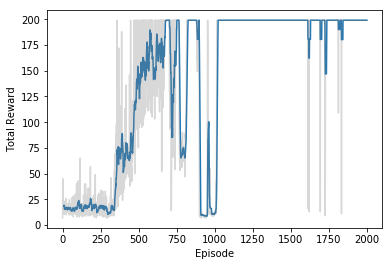

In [13]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [13]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/cartpole.ckpt


In [184]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.